In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# Step 1: Load and Clean the Dataset
data_path = 'data_set.txt'  # Update with your file path
data = pd.read_csv(data_path, delimiter='\t', encoding='ISO-8859-1')

# Print data 
print(data.info())
print(data.head())

# Drop any categorical/textual data  to avoid problem with no numeric data
data_cleaned = data.drop(columns=['Kommun_name'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Kommun_code            207 non-null    int64  
 1   Year                   207 non-null    int64  
 2   Kommun_name            207 non-null    object 
 3   Revenue                207 non-null    int64  
 4   Employee               207 non-null    int64  
 5   Population             207 non-null    int64  
 6   Population_University  207 non-null    int64  
 7   Percent_University     207 non-null    float64
 8   Productivity           207 non-null    float64
 9   SalesIndex             207 non-null    float64
 10  Infrast                207 non-null    int64  
 11  Border                 207 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 19.5+ KB
None
   Kommun_code  Year     Kommun_name  Revenue  Employee  Population  \
0         2583  2010       H

In [4]:
# Step 2: Normalize and Apply PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_cleaned)

pca = PCA(n_components=0.95)  # Retain 95% of the variance
pca_data = pca.fit_transform(scaled_data)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Explained variance ratio: [0.53878699 0.13576938 0.1035411  0.08503222 0.06840349 0.0613565 ]


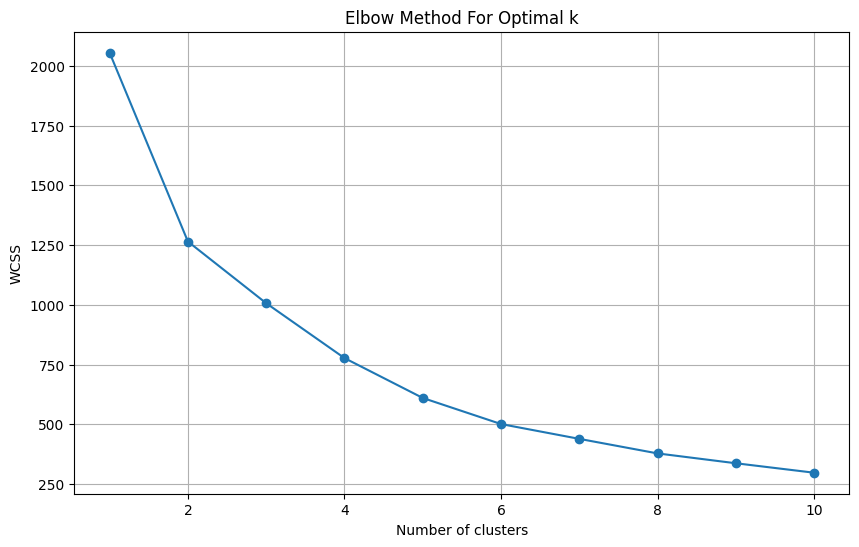

In [5]:
# Step 3: Elbow Method for Optimum Number of Clusters
wcss = []
n_range = range(1, 11)
for n in n_range:
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [6]:
# Step 4: K-Means Clustering
optimal_k = 4  # Based on the elbow plot, assuming 4 is the optimal number with the biggest break
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(pca_data)

In [7]:
# Step 5: Append Cluster Labels to Original Dataframe
data['Cluster'] = clusters

In [8]:
# Step 6: Append 'has_ikea' Column
city_with_ikea = ["Borlänge", "Gävle", "Göteborg", "Haparanda", "Helsingborg",
                 "Jönköping", "Kalmar", "Karlstad", "Linköping", "Malmö",
                 "Stockholm", "Sundsvall", "Uddevalla", "Umeå", "Uppsala",
                 "Västerås", "Älmhult", "Örebro"]

data['has_ikea'] = data['Kommun_name'].isin(city_with_ikea).astype(int)

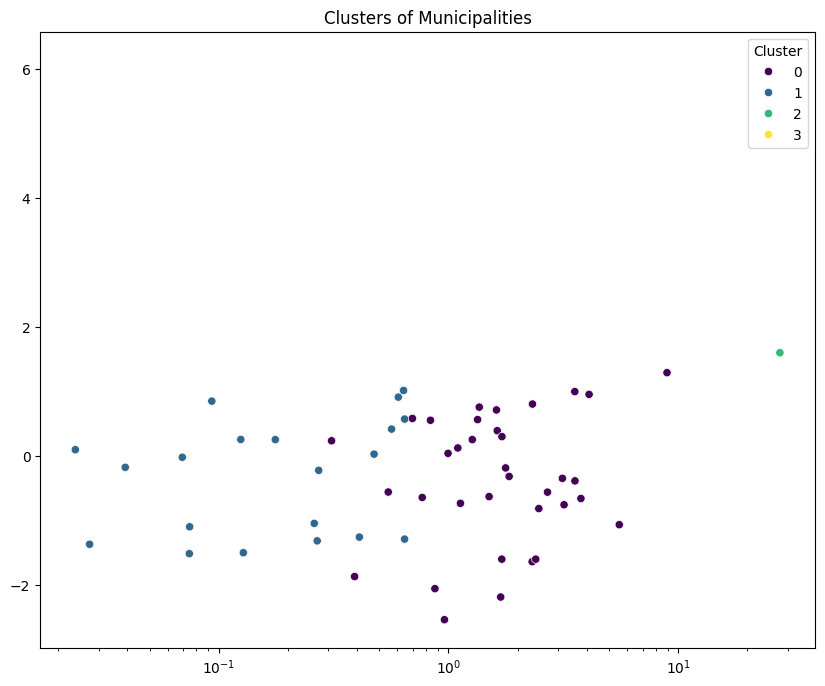

In [9]:
# Step 7: Explore the Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=data['Cluster'], palette='viridis')
plt.title('Clusters of Municipalities')
plt.xscale('log') # To improve the visualization (extented visualization)
plt.show()

In [11]:
# Step 8: Analysis and Recommendations
# Exclude locations with existing IKEA stores
data_cleaned = data[data['has_ikea'] == 0].copy()

# To not make an analyse on 1 or few topic we take the most important
criteria_composite = ['Revenue', 'Population', 'Productivity', 'SalesIndex']

# Avoid SettingWithCopyWarning// ERROR I get during test OK NOW
scaler = MinMaxScaler() # To have a scale between 0 and 1 (First attempt doesnt have this row)
data_cleaned.loc[:, criteria_composite] = scaler.fit_transform(data_cleaned[criteria_composite])

# Calculate a composite score useful when a choice depend on many criteria (Scale from 0 to 1)
data_cleaned['CompositeScore'] = data_cleaned[criteria_composite].mean(axis=1)

# Select and print the 3 best cities depend on Composite score
top_3 = data_cleaned.groupby('Cluster').apply(lambda df: df.nlargest(1, 'CompositeScore'))
print("Top candidates for new IKEA stores:\n", top_3[['Kommun_name', 'CompositeScore', 'Cluster']])

Top candidates for new IKEA stores:
              Kommun_name  CompositeScore  Cluster
Cluster                                          
0       9       Huddinge        0.813678        0
1       171  Trollhättan        0.316686        1
3       169    Strömstad        0.179643        3


The best choice according to our study is Huddinge with a very high score of 81% and far away behind we have Trollhättan and Strömstad
